In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from utils.data import get_dataset_paths
from utils.data import Marconi100Dataset
from utils.data import UnfoldedDataset
from utils.training import training_loop

from algos.deep_fib.core import get_masks
from algos.deep_fib.core import DeepFIBEngine
from algos.deep_fib.sci_net import SCINet


In [3]:
paths = get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [4]:
m_data_train = Marconi100Dataset(train, scaling="minmax")
m_data_test = Marconi100Dataset(test, scaling="minmax")


Loading:  57%|█████▋    | 128/224 [04:53<04:14,  2.65s/it]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

horizon = 1024
stride = 512
n_masks = 100

batch_size = 32

num_encoder_levels = 2

log_dir = "./outputs/deep_fib"
lr = 1e-4
num_epochs = 10

hidden = None
input_dim = 460
hidden_size = 4
kernel_size = 3
dropout = 0.5

anomaly_threshold = 0.1  # to be tuned


In [ ]:
dataset_train = UnfoldedDataset(m_data_train, horizon=horizon, stride=stride)
dataset_test = UnfoldedDataset(m_data_test, horizon=horizon, stride=stride)

masks = get_masks(horizon, n_masks).float()

len(dataset_train), len(dataset_test), masks.size()


In [ ]:
train_loader = DataLoader(
    dataset_train,
    batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    dataset_test,
    batch_size,
    shuffle=False,
)
len(train_loader), len(test_loader)


In [ ]:
model = SCINet(
    output_len=horizon,
    input_len=horizon,
    num_encoder_levels=num_encoder_levels,
    hidden_decoder_sizes=hidden,
    input_dim=input_dim,
    hidden_size=hidden_size,
    kernel_size=kernel_size,
    dropout=dropout,
).float()

engine = DeepFIBEngine(anomaly_threshold, masks)

optim = Adam(model.parameters(), lr=lr)
lr_sched = CosineAnnealingLR(optim, num_epochs)


In [ ]:
with SummaryWriter(log_dir) as writer:
    training_loop(
        model=model,
        engine=engine,
        num_epochs=num_epochs,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        device=device,
        optimizer=optim,
        lr_scheduler=lr_sched,
        writer=writer,
        save_path=log_dir + "/models",
    )


# Test

In [9]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter
import numpy as np
from sklearn.model_selection import train_test_split

from utils.data import get_dataset_paths
from utils.data import Marconi100Dataset
from utils.data import UnfoldedDataset
from utils.metrics import compute_metrics
from utils.modutils import load_model

from algos.deep_fib.core import get_masks
from algos.deep_fib.core import residual_error
from algos.deep_fib.core import DeepFIBEngine
from algos.deep_fib.sci_net import SCINet

from tqdm import tqdm
from collections import defaultdict

In [2]:
paths = get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)

m_data_test = Marconi100Dataset(test, scaling="minmax")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Loading: 100%|██████████| 25/25 [00:48<00:00,  1.93s/it]

cuda


In [3]:
import json

horizon = 1024
stride = 512
batch_size = 32

cfg_path = "./outputs/deep_fib_low_lr/config.json"
model_path = "./outputs/deep_fib_low_lr/models/model_29.pth"

with open(cfg_path, "r") as f:
    config = json.load(f)

config

{'output_len': 1024,
 'input_len': 1024,
 'num_encoder_levels': 3,
 'hidden_decoder_sizes': [512],
 'input_dim': 460,
 'hidden_size': 2,
 'kernel_size': 3,
 'dropout': 0.5}

In [4]:
dataset_test = UnfoldedDataset(m_data_test, horizon=horizon, stride=stride)

print(len(dataset_test))

test_loader = DataLoader(
    dataset_test,
    batch_size,
    shuffle=False,
)
print(len(test_loader))

647
21


In [5]:
model = SCINet(**config).float()

load_model(model, model_path, device)

SCINet(
  (encoder): EncoderTree(
    (workingblock): SCINetBlock(
      (rho): Interactor(
        (0): ReplicationPad1d((2, 2))
        (1): Conv1d(460, 920, kernel_size=(3,), stride=(1,))
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
        (4): Conv1d(920, 460, kernel_size=(3,), stride=(1,))
        (5): Tanh()
      )
      (eta): Interactor(
        (0): ReplicationPad1d((2, 2))
        (1): Conv1d(460, 920, kernel_size=(3,), stride=(1,))
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
        (4): Conv1d(920, 460, kernel_size=(3,), stride=(1,))
        (5): Tanh()
      )
      (phi): Interactor(
        (0): ReplicationPad1d((2, 2))
        (1): Conv1d(460, 920, kernel_size=(3,), stride=(1,))
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Dropout(p=0.5, inplace=False)
        (4): Conv1d(920, 460, kernel_size=(3,), stride=(1,))
        (5): Tanh()

In [12]:
with torch.no_grad():
    model.eval()

    _all_errors = []
    _all_labels = []

    for batch in tqdm(test_loader):
        inputs = batch["data"].to(device)
        targets = inputs.detach().clone()

        preds = model(inputs)

        labels = batch["label"]
        errors = residual_error(preds, targets)

        _all_errors.append(errors.cpu())
        _all_labels.append(labels)

    all_errors = torch.concat(_all_errors)
    all_labels = torch.concat(_all_labels)

    print(all_errors.size(), all_labels.size())

100%|██████████| 21/21 [00:17<00:00,  1.19it/s]

torch.Size([647, 1024]) torch.Size([647, 1024])


In [23]:
step = 0.01
thresholds = np.arange(0, all_errors.max() + step, step)

f1, prec, rec = [], [], []
for at in thresholds:
    labels = (all_errors > at).to(torch.int)
    metrics = compute_metrics(labels.flatten(), all_labels.flatten())
    f1.append(metrics["f1"])
    prec.append(metrics["precision"])
    rec.append(metrics["recall"])

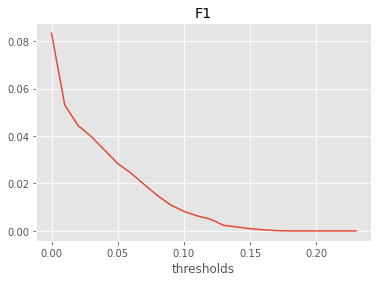

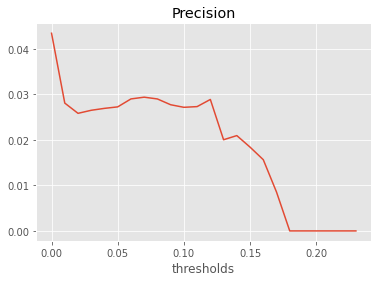

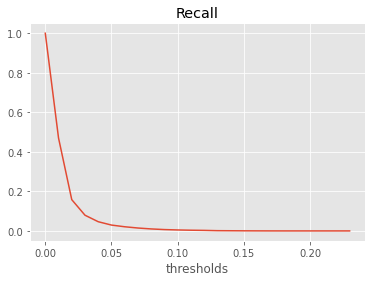

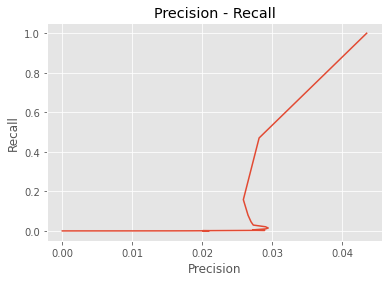

In [29]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

plt.title("F1")
plt.plot(thresholds, f1)
plt.xlabel("thresholds")
plt.show()

plt.title("Precision")
plt.plot(thresholds, prec)
plt.xlabel("thresholds")
plt.show()

plt.title("Recall")
plt.plot(thresholds, rec)
plt.xlabel("thresholds")
plt.show()

plt.title("Precision - Recall")
plt.plot(prec, rec)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

In [13]:
anomaly_threshold = 0.1 # to be tuned
engine = DeepFIBEngine(anomaly_threshold)
test_scalars = defaultdict(list)
for batch in tqdm(test_loader, leave=False):
    batch = {k: d.to(device) for k, d in batch.items()}
    rets = engine.val_step(model, batch)
    for tag, val in rets.items():
        test_scalars[tag].append(float(val))

print(anomaly_threshold)
for tag, val in test_scalars.items():
    print(tag, np.mean(val))

0.0
f1 0.0807458393807922
precision 0.04374435313400768
recall 1.0
loss 0.018629885278642178



0.1
f1 0.010690747610559421
precision 0.024665161035954952
recall 0.007982732934622271
loss 0.018629885278642178



0.2
f1 0.0
precision 0.0
recall 0.0
loss 0.018629885278642178



0.30000000000000004
f1 0.0
precision 0.0
recall 0.0
loss 0.018629885278642178



0.4
f1 0.0
precision 0.0
recall 0.0
loss 0.018629885278642178



0.5
f1 0.0
precision 0.0
recall 0.0
loss 0.018629885278642178



0.6000000000000001
f1 0.0
precision 0.0
recall 0.0
loss 0.018629885278642178



KeyboardInterrupt: 